<a href="https://colab.research.google.com/github/pachterlab/monod/blob/anndata/Monod_demo_new.ipynb?short_path=e568791" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Monod* on Colab

In the current notebook, we apply *Monod* to identify differentially regulated genes between GABAergic and glutamatergic cell types in a single Allen dataset. 

# Inference pipeline

## Install prerequisites

In [1]:
# # %%capture
# # !pip install -i https://test.pypi.org/simple/ -U --extra-index-url https://pypi.org/simple   monod  
# # !pip install -i https://pypi.org/simple/  monod  
# !pip install monod

Let's make sure that the version is correct.

In [2]:
!pip show monod

Name: monod
Version: 0.2.9.0
Summary: the Monod package fits CME models to sequencing data.
Home-page: https://github.com/pachterlab/monod
Author: Gennady Gorin, Lior Pachter
Author-email: ggorin@caltech.edu, lpachter@caltech.edu
License: 
Location: /home/cat/.conda/envs/myenv/lib/python3.12/site-packages
Requires: anndata, loompy, matplotlib, numdifftools, numpy, pytz, scikit-learn, scipy, tqdm
Required-by: 


## Import data

In [3]:
# ! git clone https://github.com/pachterlab/monod_examples.git

In [4]:
# !rm -r sample_data

In [5]:
# !mv monod_examples/* .

In [6]:
# !rm -r monod_examples

In [7]:
# !mv sample_data/* .

In [8]:
# !rmdir sample_data

In [9]:
# !cat allen_C01_gaba.tar.gz.* | tar xzvf -

In [10]:
# !mv home/ggorin/projects/monod_examples/sample_data/allen_C01_gaba.loom .

In [11]:
# !cat allen_C01_glu.tar.gz.* | tar xzvf -

In [12]:
# !mv home/ggorin/projects/monod_examples/sample_data/allen_C01_glu.loom .

In [13]:
# !rm -r  ./home

In [14]:
# !rm *.tar.*

## Import package components

In [2]:
# import monod
# from monod import preprocess, extract_data, cme_toolbox, inference, analysis

import matplotlib.pyplot as plt
import numpy as np
import anndata
from IPython.display import display, Markdown
import scanpy as sc

In [95]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.DEBUG)
import warnings
warnings.filterwarnings("ignore") #warning suppression within script is not respected by colab
warnings.simplefilter('ignore')

In [146]:
# execfile("src/monod/preprocess.py")
import sys

sys.path.insert(0, '/home/cat/monod/src/monod')

import extract_data, cme_toolbox, inference, analysis, mminference
import importlib

importlib.reload(extract_data)
importlib.reload(inference)
importlib.reload(cme_toolbox)
importlib.reload(analysis)
importlib.reload(mminference)

<module 'mminference' from '/home/cat/monod/src/monod/mminference.py'>

### Load data and filter if desired

In [141]:
gaba_adata = anndata.read_h5ad('./allen_C01_gaba.h5ad')
# gaba_adata = anndata.read_h5ad('./gaba_example.h5ad')

# N.B. The adata should have var_names as gene names which match the transcriptome.
try:
    gene_names = gaba_adata.var['gene_name'].astype(str)
    gaba_adata.var_names = gene_names
except:
    pass

gaba_adata.var_names_make_unique()

In [143]:
gaba_adata

AnnData object with n_obs × n_vars = 728 × 32285
    obs: 'barcode'
    var: 'gene_name'
    layers: 'matrix', 'spliced', 'unspliced'

Create knee plot.

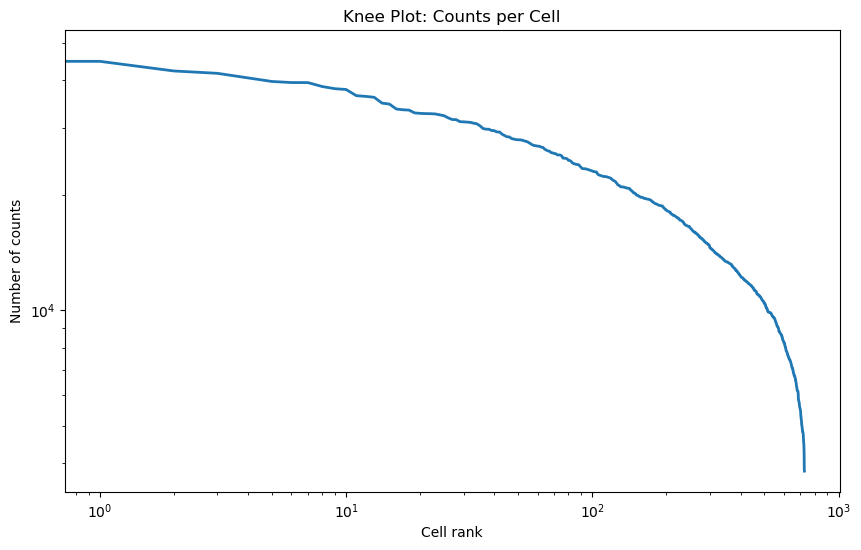

In [128]:
# Calculate number of genes per cell
sc.pp.calculate_qc_metrics(gaba_adata, inplace=True)

# Sort cells by number of genes
total_counts = np.sort(gaba_adata.obs.total_counts)[::-1]

# Create range for x-axis
cell_range = range(len(total_counts))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(cell_range, total_counts, linewidth=2)

plt.xlabel('Cell rank')
plt.ylabel('Number of counts')
plt.title('Knee Plot: Counts per Cell')

# Add log scales
plt.xscale('log')
plt.yscale('log')

plt.show()

Filter by number of counts if desired.

In [129]:
threshold = 10
sc.pp.filter_cells(gaba_adata, min_counts=threshold)

Combine mature and ambiguous layers into a spliced layer if necessary.

In [140]:
# # Check if required layers exist
# if 'mature' not in gaba_adata.layers or 'ambiguous' not in gaba_adata.layers:
#     raise ValueError("Both 'mature' and 'ambiguous' layers must exist in the AnnData object")

# # Sum the layers
# gaba_adata.layers['spliced'] = gaba_adata.layers['mature'] + gaba_adata.layers['ambiguous']

## Set up model and perform inference.

Optional Fit Parameters

In [130]:
transcriptome_filepath =  './monod_examples/polyA_ref/gg_200524_mouse_genome_polyA_cum_1'
demo_genes = ['Eif5b','Xrcc5','Klhl12','Rgs7','Thsd7b']
lb, ub, samp_lb, samp_ub, gridsize = None, None, None, None, None # Can add as keywords if desired.

The expected modalities for this model are: ['unspliced', 'spliced']
If your anndata layers have different names, please give a modality dictionary of the form: modality_name_dict  = {'spliced':your_spliced_layer_name, 'unspliced':your_unspliced_layer_name} 
INFO:root:No dataset name given (dataset_string=None). Saving as Bursty_Poisson
INFO:root:Directory Bursty_Poisson already exists.
INFO:root:Beginning data extraction.
INFO:root:Dataset: Bursty_Poisson
INFO:root:Using default gene filtering parameters
is sparse
INFO:root:Added lengths


/home/cat/.conda/envs/myenv/lib/python3.12/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/cat/.conda/envs/myenv/lib/python3.12/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


INFO:root:728 cells detected.
3578 genes retained after expression filter.
INFO:root:-3 random genes selected.
INFO:root:Total of 5 genes selected.
INFO:root:Data extracted
INFO:root:Search data created.
INFO:root:Directory Bursty_Poisson/Bursty_Poisson_6x7 already exists.
INFO:root:Global inference parameters stored to Bursty_Poisson/Bursty_Poisson_6x7/parameters.pr.
INFO:root:Global inference parameters set.
INFO:root:Starting parallelized grid scan.


100%|█████████████████████████████████| 42/42 [00:06<00:00,  6.00it/s]

INFO:root:Parallelized grid scan complete.


INFO:root:All grid point data cleaned from disk.
INFO:root:Directory Bursty_Poisson/Bursty_Poisson_6x7/analysis_figures already exists.
INFO:root:Grid scan results stored to Bursty_Poisson/Bursty_Poisson_6x7/grid_scan_results.res.
INFO:root:Runtime: 10.0 seconds.
INFO:root:Grid points fit.
INFO:root:Optimal parameters found.
INFO:root:Optimal parameters saved to anndata, under .var attributes in the form: "$\gamma$". Note that the parameters are given in log-base 10.
INFO:root:AIC values calculated and saved under .var attribute: AIC.
INFO:root:Computing local Hessian.
INFO:root:Starting non-parallelized Hessian computation.
INFO:root:Non-parallelized Hessian computation complete.
INFO:root:Standard error of the MLE computation complete. Runtime: 6.7 seconds.
INFO:root:Uncertainties per gene calculated, saved to anndata in .var attribute of the form: "error_$\gamma$". Note that the errors are given in log-base 10.


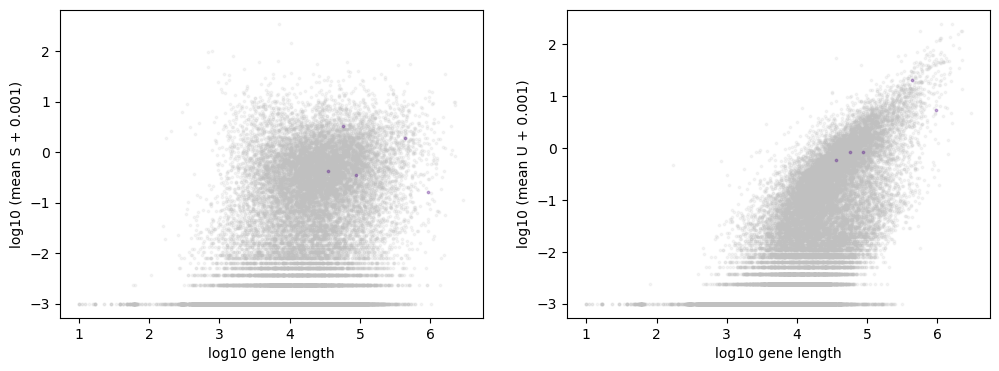

In [147]:
# Define model.
fitmodel = cme_toolbox.CMEModel('Bursty','Poisson')

# Define number of clusters and epochs if using meK-Means, otherwise set to None.
mek_means_params = None # (4,2)

gaba_adata = inference.perform_inference(gaba_adata, fitmodel, genes_to_fit=demo_genes,
                                         transcriptome_filepath=transcriptome_filepath,
                                         num_cores=16, mek_means_params=mek_means_params, n_genes=2) 

INFO:root:Directory glu_example already exists.
INFO:root:Beginning data extraction.
INFO:root:Dataset: glu_example
INFO:root:Using default gene filtering parameters
INFO:root:Duplicate variable names found. Making them unique...
is sparse
INFO:root:Added lengths


/home/cat/.conda/envs/myenv/lib/python3.12/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/cat/.conda/envs/myenv/lib/python3.12/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


INFO:root:6629 cells detected.
5520 genes retained after expression filter.
INFO:root:0 random genes selected.
INFO:root:Total of 2 genes selected.
INFO:root:Data extracted
INFO:root:Search data created.
INFO:root:Directory glu_example/Bursty_Poisson_6x7 already exists.
INFO:root:Global inference parameters stored to glu_example/Bursty_Poisson_6x7/parameters.pr.
INFO:root:Global inference parameters set.
INFO:root:Starting parallelized grid scan.


100%|█████████████████████████████████| 42/42 [00:01<00:00, 22.44it/s]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory glu_example/Bursty_Poisson_6x7/analysis_figures already exists.
INFO:root:Grid scan results stored to glu_example/Bursty_Poisson_6x7/grid_scan_results.res.
INFO:root:Runtime: 6.9 seconds.
INFO:root:Grid points fit.
INFO:root:Optimal parameters found.
INFO:root:Optimal parameters saved to anndata, under .var attributes in the form: "$\gamma$". Note that the parameters are given in log-base 10.
INFO:root:AIC values calculated and saved under .var attribute: AIC.
INFO:root:Computing local Hessian.
INFO:root:Starting non-parallelized Hessian computation.
INFO:root:Non-parallelized Hessian computation complete.
INFO:root:Standard error of the MLE computation complete. Runtime: 1.3 seconds.
INFO:root:Uncertainties per gene calculated, saved to anndata in .var attribute of the form: "error_$\gamma$". Note that the errors are given in log-base 10.


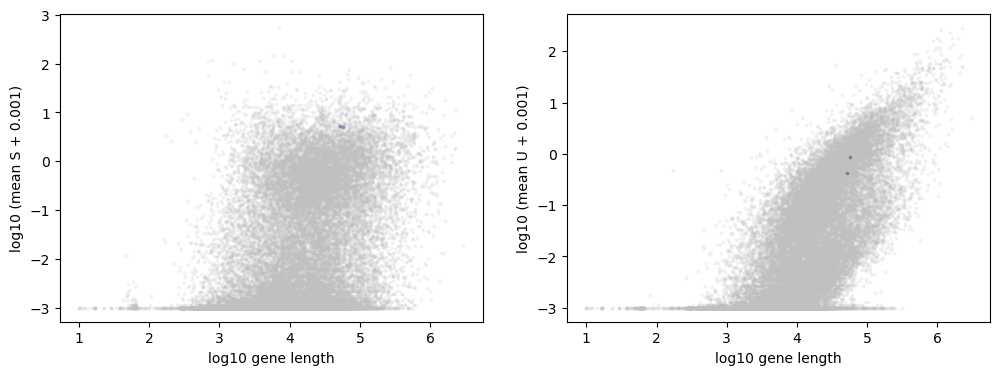

In [137]:
# Fix the genes to be the same as for the gaba data.
genes_to_fit = [i for i in gaba_adata.var_names]
n_genes = len(genes_to_fit)

glu_adata = inference.perform_inference('./glu_example.h5ad', fitmodel, n_genes=n_genes, genes_to_fit=genes_to_fit,
                transcriptome_filepath=transcriptome_filepath, mek_means_params=mek_means_params, num_cores=16)

## Access gene info.

In [42]:
# AIC.
display(gaba_adata.var[['AIC']])

# Optimum biological parameters.
display(gaba_adata.var[[i for i in gaba_adata.var.keys() if 'param' in i]])

# Uncertainties from Hessian.
display(gaba_adata.var[[i for i in gaba_adata.var.keys() if 'sigma' in i]])

,AIC
gene_name,
AC149090.1,6179.065643
Arpc2,4943.163552
Adss,3859.666554
Map2,7722.527721
Eif5b,4812.523207
...,...
Kdm5c,4762.557716
Tbl1x,6430.451118
Fmr1,3794.398566


,cluster_0_param_$\log_{10} b$,cluster_1_param_$\log_{10} b$,cluster_2_param_$\log_{10} b$,cluster_3_param_$\log_{10} b$,cluster_0_param_$\log_{10} \beta$,cluster_1_param_$\log_{10} \beta$,cluster_2_param_$\log_{10} \beta$,cluster_3_param_$\log_{10} \beta$,cluster_0_param_$\log_{10} \gamma$,cluster_1_param_$\log_{10} \gamma$,cluster_2_param_$\log_{10} \gamma$,cluster_3_param_$\log_{10} \gamma$
gene_name,,,,,,,,,,,,
AC149090.1,1.691444,2.849961,2.725742,2.502544,-1.546867,-0.537951,-0.612024,-0.484712,-0.572811,0.504199,0.362911,0.591887
Arpc2,1.524752,1.957034,1.782104,1.416104,-0.882288,-0.524030,-0.625022,-0.712286,-0.301707,-0.181824,-0.161329,-0.312416
Adss,1.566908,1.358408,1.452790,1.201045,-0.564778,-0.723185,-0.579463,-0.723438,-0.111456,-0.615922,-0.321979,-0.277705
Map2,1.625210,1.754703,1.809397,1.523121,-0.792261,-0.620238,-0.405942,-0.582949,-0.672878,-0.644291,-0.445982,-0.527424
Eif5b,1.504929,1.593354,1.532227,1.195247,-0.610170,-0.386492,-0.506536,-0.532540,-0.514864,-0.586612,-0.599945,-0.531628
...,...,...,...,...,...,...,...,...,...,...,...,...
Kdm5c,1.598697,2.141340,1.818565,1.643827,-0.921272,-0.424489,-0.746197,-0.662727,0.043401,0.449121,0.140827,0.221475
Tbl1x,1.831761,1.907698,2.003437,1.499693,-0.436055,-0.309921,-0.549123,-0.413555,-0.041052,-0.155999,-0.247877,-0.163857
Fmr1,0.987945,1.400955,1.436376,1.373121,-0.919558,-0.560595,-0.625356,-0.318551,-0.647240,-0.457809,-0.477419,-0.096188


,cluster_0_sigma_$\log_{10} b$,cluster_0_sigma_$\log_{10} \beta$,cluster_0_sigma_$\log_{10} \gamma$,cluster_1_sigma_$\log_{10} b$,cluster_1_sigma_$\log_{10} \beta$,cluster_1_sigma_$\log_{10} \gamma$,cluster_2_sigma_$\log_{10} b$,cluster_2_sigma_$\log_{10} \beta$,cluster_2_sigma_$\log_{10} \gamma$,cluster_3_sigma_$\log_{10} b$,cluster_3_sigma_$\log_{10} \beta$,cluster_3_sigma_$\log_{10} \gamma$
gene_name,,,,,,,,,,,,
AC149090.1,0.190946,0.179840,0.192659,0.071293,0.066980,0.069667,0.078101,0.074361,0.076504,0.080132,0.075639,0.080409
Arpc2,0.218228,0.217525,0.218637,0.085939,0.083409,0.085601,0.117883,0.115141,0.118017,0.143925,0.142076,0.143464
Adss,0.196069,0.193257,0.196391,0.165981,0.166633,0.165698,0.171422,0.169140,0.171449,0.216086,0.214038,0.215551
Map2,0.088541,0.086443,0.089462,0.061446,0.058857,0.062073,0.062280,0.058732,0.062892,0.062880,0.061067,0.063643
Eif5b,0.160636,0.159825,0.160146,0.100574,0.102014,0.099474,0.116337,0.116549,0.115733,0.156388,0.155690,0.156146
...,...,...,...,...,...,...,...,...,...,...,...,...
Kdm5c,0.207600,0.204331,0.208974,0.085890,0.081662,0.087748,0.131500,0.129455,0.133287,0.133988,0.131988,0.135882
Tbl1x,0.092617,0.089230,0.093905,0.066780,0.062324,0.067221,0.063034,0.060669,0.063324,0.080052,0.077704,0.081244
Fmr1,0.404690,0.404220,0.404196,0.155601,0.154637,0.155185,0.155445,0.154198,0.155557,0.141745,0.140338,0.142493


In [7]:
# AIC.
display(glu_adata.var[['AIC']])

# Optimum biological parameters.
display(glu_adata.var[[i for i in glu_adata.var.keys() if 'param' in i]])

# Uncertainties from Hessian.
display(glu_adata.var[[i for i in glu_adata.var.keys() if 'sigma' in i]])

,AIC
gene_name,
Eif5b,49857.411552
Xrcc5,20148.521348
Klhl12,21186.010134
Rgs7,80981.945756
Thsd7b,29602.460586


,cluster_0_param_$\log_{10} b$,cluster_1_param_$\log_{10} b$,cluster_2_param_$\log_{10} b$,cluster_3_param_$\log_{10} b$,cluster_0_param_$\log_{10} \beta$,cluster_1_param_$\log_{10} \beta$,cluster_2_param_$\log_{10} \beta$,cluster_3_param_$\log_{10} \beta$,cluster_0_param_$\log_{10} \gamma$,cluster_1_param_$\log_{10} \gamma$,cluster_2_param_$\log_{10} \gamma$,cluster_3_param_$\log_{10} \gamma$
gene_name,,,,,,,,,,,,
Eif5b,1.693350,1.632380,1.697104,1.695712,-0.154302,-0.305651,-0.298774,-0.361132,-0.428740,-0.540721,-0.536176,-0.581695
Xrcc5,0.770588,1.069279,1.065671,1.492431,-0.173915,-0.520106,-1.458276,-0.165390,0.197312,0.084446,-0.492151,0.468608
Klhl12,1.275481,2.475754,1.276451,0.418641,-0.630846,2.324929,-0.738872,-1.800000,0.070023,3.500000,-0.182428,-1.051627
Rgs7,2.047542,2.084515,2.306992,2.275037,-0.467517,-0.403761,-0.417630,-0.324145,0.076919,0.145071,0.317737,0.228767
Thsd7b,3.052513,1.591870,1.647377,1.624460,2.500000,0.182948,0.264572,0.076960,3.466164,0.877209,1.134217,0.797739


,cluster_0_sigma_$\log_{10} b$,cluster_0_sigma_$\log_{10} \beta$,cluster_0_sigma_$\log_{10} \gamma$,cluster_1_sigma_$\log_{10} b$,cluster_1_sigma_$\log_{10} \beta$,cluster_1_sigma_$\log_{10} \gamma$,cluster_2_sigma_$\log_{10} b$,cluster_2_sigma_$\log_{10} \beta$,cluster_2_sigma_$\log_{10} \gamma$,cluster_3_sigma_$\log_{10} b$,cluster_3_sigma_$\log_{10} \beta$,cluster_3_sigma_$\log_{10} \gamma$
gene_name,,,,,,,,,,,,
Eif5b,0.026837,0.026984,0.026563,0.027735,0.027689,0.027553,0.266829,0.263044,0.265412,0.021705,0.021562,0.021589
Xrcc5,0.158003,0.155903,0.158719,0.081920,0.081048,0.082948,0.479165,0.474528,0.485876,0.036905,0.035590,0.038814
Klhl12,0.083848,0.083076,0.084453,0.325401,0.157831,0.274955,0.609521,0.601580,0.604855,0.120031,0.119822,0.120244
Rgs7,0.016758,0.015637,0.017299,0.016179,0.014916,0.016724,0.195931,0.148018,0.196901,0.012851,0.011660,0.013031
Thsd7b,0.169173,0.055523,0.120436,0.021640,0.017005,0.030857,0.300465,0.205697,0.395996,0.016399,0.013198,0.023144


## Plot parameter distributions.

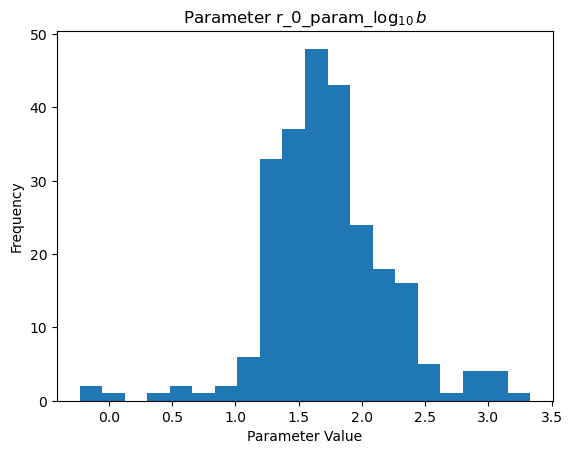

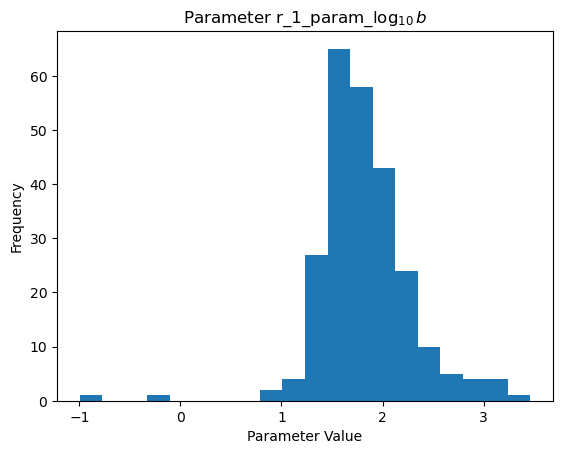

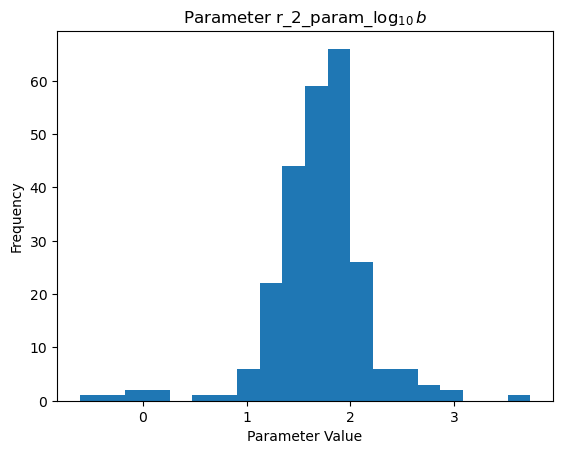

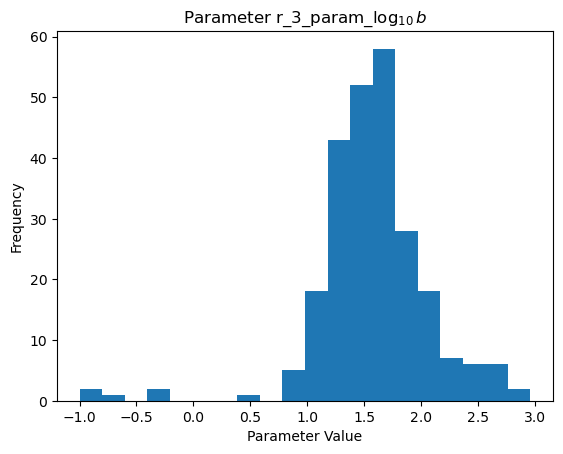

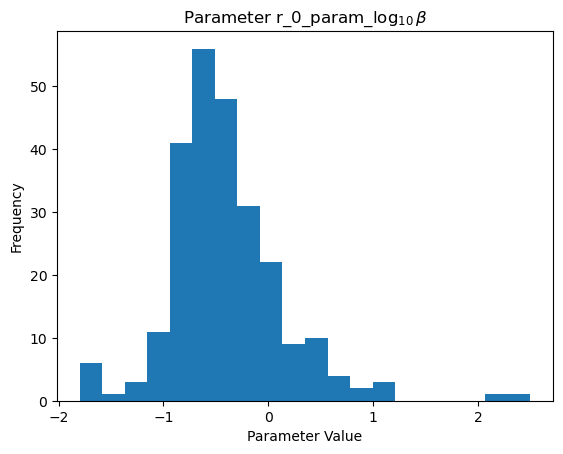

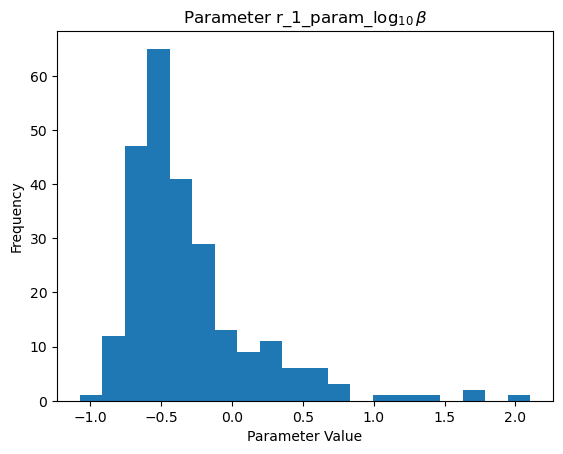

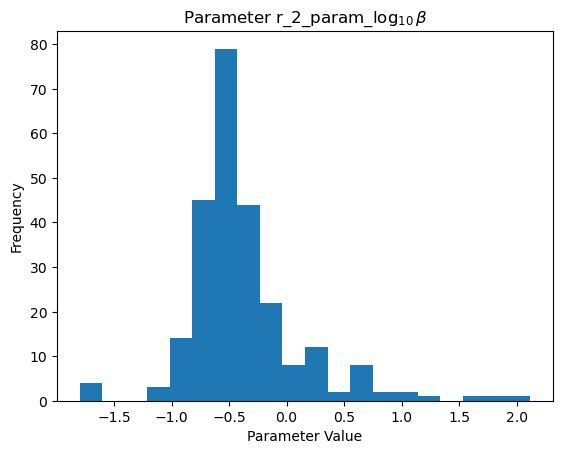

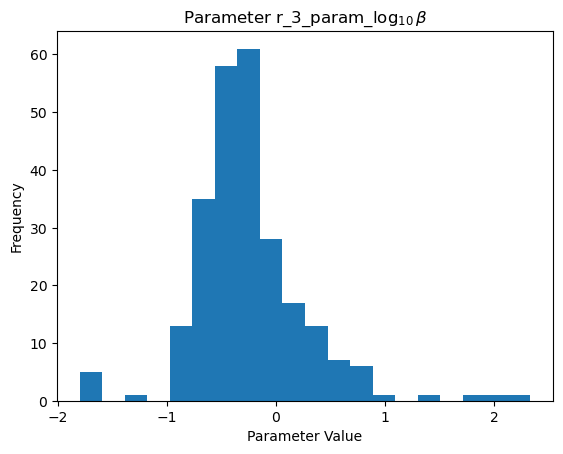

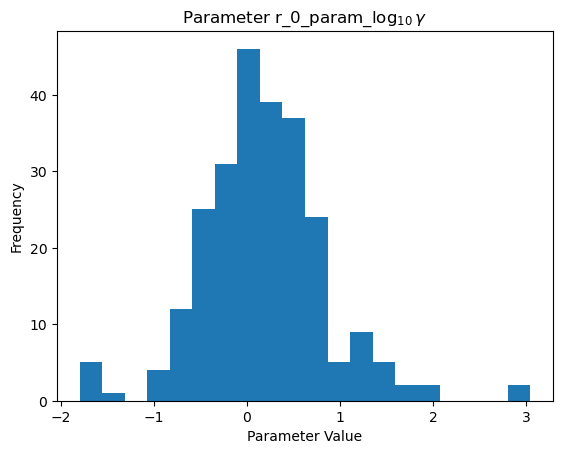

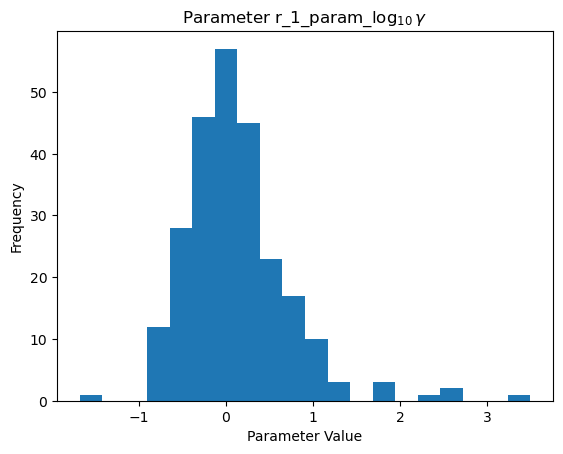

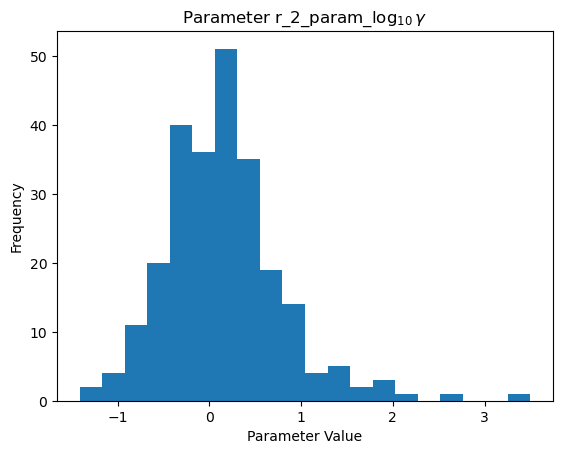

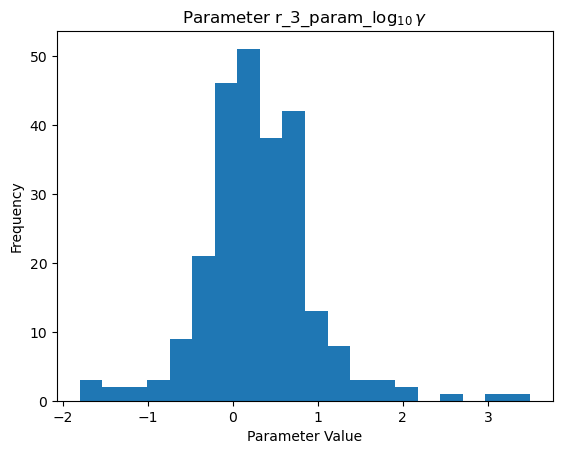

In [43]:
param_names = [i for i in gaba_adata.var.keys() if 'param' in i]
for name in param_names:
    plt.hist(gaba_adata.var[name], bins=20)
    plt.title('Parameter ' + name[6:])
    plt.xlabel('Parameter Value')
    plt.ylabel('Frequency')
    # plt.savefig(search_result.inference_string + '/parameter_dist_'+ str(i))#'/parameter_dist_{}'.format(
    plt.show()

In [12]:
# param_names = [i for i in gaba_adata.var.keys() if 'param' in i]
# for name in param_names:
#     plt.hist(gaba_adata.var[name], bins=20)
#     plt.title('Parameter ' + name[6:])
#     plt.xlabel('Parameter Value')
#     plt.ylabel('Frequency')
#     # plt.savefig(search_result.inference_string + '/parameter_dist_'+ str(i))#'/parameter_dist_{}'.format(
#     plt.show()
#     # print(gaba_adata.var[name] - glu_adata.var[name])

## Plot parameter values against gene length.

# Analysis (to be implemented)

## Reject genes.

In [44]:
# # Add rejection filter to adata.
gaba_adata = inference.reject_genes(gaba_adata, reject_at_bounds=False, mek_means=True, save_csq=True)#, threshold=-1, use_hellinger=False, reject_at_bounds=False)
glu_adata = inference.reject_genes(glu_adata, reject_at_bounds=False, mek_means=True, save_csq=True)#, threshold=-1, use_hellinger=False, reject_at_bounds=False)

# Show rejected genes.
display(glu_adata.var[[i for i in glu_adata.var.keys() if 'rejected' in i]])
display(gaba_adata.var[[i for i in gaba_adata.var.keys() if 'rejected' in i]])

# Show chi-squared values, and other rejection statistics if saved.
display(glu_adata.var[[i for i in glu_adata.var.keys() if 'csq' in i or 'pval' in i or 'hellinger' in i]])
display(gaba_adata.var[[i for i in gaba_adata.var.keys() if 'csq' in i or 'pval' in i or 'hellinger' in i]])

# # # Save chi-square values.
# chi_squareds_glu,  chi_squareds_gaba = glu_adata.var['csq'], gaba_adata.var['csq']

INFO:root:Chi-square computation complete. Rejected 41 genes out of 249. Runtime: 0.3 seconds.
INFO:root:Chi-square computation complete. Rejected 60 genes out of 249. Runtime: 0.4 seconds.
INFO:root:Chi-square computation complete. Rejected 36 genes out of 249. Runtime: 0.4 seconds.
INFO:root:Chi-square computation complete. Rejected 20 genes out of 249. Runtime: 0.4 seconds.
INFO:root:Chi-square computation complete. Rejected 1 genes out of 5. Runtime: 0.0 seconds.
INFO:root:Chi-square computation complete. Rejected 1 genes out of 5. Runtime: 0.0 seconds.
INFO:root:Chi-square computation complete. Rejected 0 genes out of 5. Runtime: 0.0 seconds.
INFO:root:Chi-square computation complete. Rejected 3 genes out of 5. Runtime: 0.1 seconds.


,0_rejected_genes,1_rejected_genes,2_rejected_genes,3_rejected_genes
gene_name,,,,
Eif5b,False,False,False,False
Xrcc5,False,False,False,False
Klhl12,False,False,False,True
Rgs7,True,True,False,True
Thsd7b,False,False,False,True


,0_rejected_genes,1_rejected_genes,2_rejected_genes,3_rejected_genes
gene_name,,,,
AC149090.1,False,True,False,False
Arpc2,False,False,False,False
Adss,False,False,False,False
Map2,True,True,True,True
Eif5b,False,False,False,False
...,...,...,...,...
Kdm5c,False,True,False,False
Tbl1x,False,True,True,False
Fmr1,False,False,False,False


,0_csq,1_csq,2_csq,3_csq
gene_name,,,,
Eif5b,78.515135,5.373644e+01,0.188654,156.805446
Xrcc5,7.938545,4.184524e+01,0.000000,102.843128
Klhl12,81.890414,2.656669e-29,2.385356,975.653310
Rgs7,485.962478,4.226337e+02,0.000000,708.992284
Thsd7b,7.683852,4.315455e+02,0.300851,842.897960


,0_csq,1_csq,2_csq,3_csq
gene_name,,,,
AC149090.1,29.829603,59.355865,29.931372,34.999432
Arpc2,12.433538,30.947586,22.458747,15.354985
Adss,5.157823,18.088035,4.088068,4.854000
Map2,122.776740,117.833873,79.567279,97.793365
Eif5b,13.421872,20.814956,30.400026,9.803786
...,...,...,...,...
Kdm5c,7.575338,55.558320,12.024349,20.013778
Tbl1x,13.252894,71.436057,130.802360,14.492019
Fmr1,6.115560,3.937402,9.107186,8.065237


## Execute differential expression analysis.

In [81]:
# If 2 anndata objects are given, parameters are compared across datasets.
if not mek_means_params:
    DE_genes, DE_filter, offs, residuals = analysis.DE_parameters(glu_adata, gaba_adata, 
                                                              viz=True, use_sigma=True)
    
# If using meK-Means, compare clusters within one dataset.
else:
    DE_genes_gaba, DE_filter_gaba, offs_gaba, residuals_gaba = analysis.DE_parameters(gaba_adata, 
                                                              viz=True, use_sigma=True, discard_rejected=True,
                                                                                     save_cluster_FCs=False)
    clusters = [i for i in DE_genes_gaba.keys()]
    DE_genes = [DE_genes_gaba[i] for i in clusters]
    param_names = gaba_adata.uns['search_result_list'][0].model.get_log_name_str()
    param_num, cluster_num = 0,0
    display(Markdown('E.g.' + param_names[param_num]))
    print(clusters[cluster_num], DE_genes[cluster_num][param_num])

display(gaba_adata.var[[i for i in gaba_adata.var.keys() if 'FC' in i]])

,"FC_$\log_{10} b$_(0, 1)","FC_$\log_{10} \beta$_(0, 1)","FC_$\log_{10} \gamma$_(0, 1)","FC_$\log_{10} b$_(2, 2)","FC_$\log_{10} \beta$_(2, 2)","FC_$\log_{10} \gamma$_(2, 2)","FC_$\log_{10} b$_(2, 3)","FC_$\log_{10} \beta$_(2, 3)","FC_$\log_{10} \gamma$_(2, 3)","FC_$\log_{10} b$_(1, 2)","FC_$\log_{10} \beta$_(1, 2)","FC_$\log_{10} \gamma$_(1, 2)"
gene_name,,,,,,,,,,,,
AC149090.1,NaN,NaN,NaN,0.0,0.0,0.0,-0.223198,0.127312,0.228976,NaN,NaN,NaN
Arpc2,0.432282,0.358257,0.119883,0.0,0.0,0.0,-0.366001,-0.087264,-0.151087,-0.174930,-0.100992,0.020495
Adss,-0.208500,-0.158407,-0.504466,0.0,0.0,0.0,-0.251745,-0.143975,0.044274,0.094382,0.143722,0.293943
Map2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Eif5b,0.088425,0.223678,-0.071748,0.0,0.0,0.0,-0.336980,-0.026004,0.068318,-0.061128,-0.120044,-0.013334
...,...,...,...,...,...,...,...,...,...,...,...,...
Kdm5c,NaN,NaN,NaN,0.0,0.0,0.0,-0.174738,0.083469,0.080647,NaN,NaN,NaN
Tbl1x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fmr1,0.413010,0.358963,0.189431,0.0,0.0,0.0,-0.063256,0.306805,0.381231,0.035421,-0.064761,-0.019610


In [27]:
# # NB changing loom to h5ad.
# adata_gaba = anndata.read_loom('monod_examples/sample_data/allen_C01_gaba.loom')
# adata_gaba.var_names = adata_gaba.var['gene_name']
# adata_gaba.obs_names = adata_gaba.obs['barcode']
# adata_gaba.obs = adata_gaba.obs.drop(columns=['barcode'])
# adata_gaba.var = adata_gaba.var.drop(columns=['gene_name'])
# adata_gaba.write('gaba_example.h5ad')

### Show some gene distributions.

[0 1 2]
Eif5b
Xrcc5
Klhl12


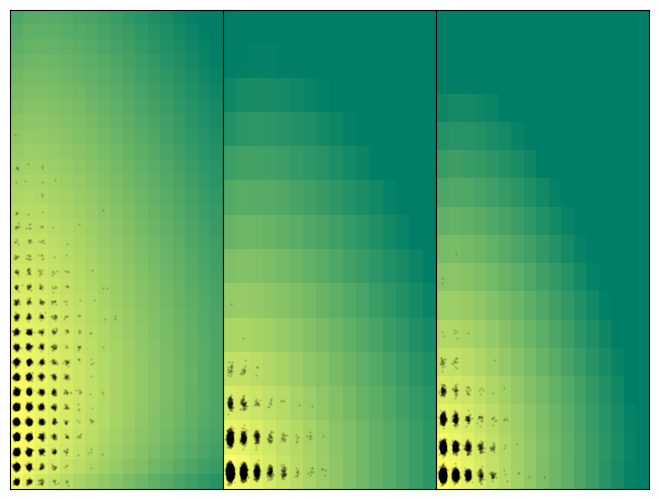

In [29]:
fitted_adata = glu_adata

search_result, search_data = fitted_adata.uns['search_result'], fitted_adata.uns['search_data']
logscale = True

sz =(1,3)
(nrows, ncols) = sz
fig1, ax1 = plt.subplots(nrows=nrows, ncols=ncols)

nax = np.prod(sz)

genes_to_plot = np.arange(nax)

genes_to_plot = np.asarray(genes_to_plot)
if genes_to_plot.dtype == bool:
    gtp_temp = np.arange(self.n_genes)
    genes_to_plot = gtp_temp[genes_to_plot]

number_of_genes_to_plot = len(genes_to_plot)
if number_of_genes_to_plot > 5:
    number_of_genes_to_plot = 5
    genes_to_plot = genes_to_plot[: 5]
if number_of_genes_to_plot > nax:  # This should no longer break...
    number_of_genes_to_plot = nax
    genes_to_plot = genes_to_plot[:nax]

j_ = 0
marg = 'joint'
modalities = ['spliced', 'unspliced']

print(genes_to_plot)
for i_ in genes_to_plot:
    lm = np.copy(search_data.M[:, i_])
    
    # TODO: generalize by adding attribute names as attribute of e.g. CMEModel
    # attributes = ['unspliced', 'spliced', 'protein']
    
    num_modalities = 2
    for i in range(num_modalities):
        if marg == modalities[i]:
            lm[:i] = 1
            lm[i+1:]=1
            
    axloc = np.unravel_index(j_, sz) if (sz[0] > 1 and sz[1] > 1) else j_

    samp = search_result.regressor_optimum[i_]
    Pa = np.squeeze(search_result.model.eval_model_pss(search_result.phys_optimum[i_], lm, samp))
    layers = np.array([i.copy() for i in search_data.layers])
    
    marg = 'joint'
    if marg == "joint":
        if logscale:
            Pa[Pa < 1e-10] = 1e-10
            Pa = np.log10(Pa)

        if num_modalities==2:
            ax1[axloc].imshow(Pa.T, aspect="auto", cmap="summer")
        elif num_modalities==3:
            ax1[axloc].imshow(Pa.sum(axis=2).T, aspect="auto", cmap="summer")
        else:
            log.error('Joint distribution plot only implemented for 2 or 3 modalities')
            
        ax1[axloc].invert_yaxis()

        jitter_magn = 0.1
        jitter = np.random.randn(2, search_result.n_cells) * jitter_magn
        ax1[axloc].scatter(
            *layers[:2, :,i_] + jitter, c="k", s=1, alpha=0.1
        )

        ax1[axloc].set_xlim([-0.5, search_data.M[0, i_] - 1.5])
        ax1[axloc].set_ylim([-0.5, search_data.M[1, i_] - 1.5])
    else:
        plot_hist_and_fit(ax1[axloc], search_data, i_, Pa, marg)
        if logscale:
            ax1[axloc].set_yscale("log")

    print(search_result.gene_names[i_])
    # if title:
    #     titlestr = search_result.gene_names[i_]
    #     if hasattr(search_result, "rejected_genes") and search_result.rejected_genes[i_]:
    #         titlestr += " (rej.)"
    #     ax1[axloc].set_title(titlestr, fontdict={"fontsize": 9})
    ax1[axloc].set_xticks([])
    ax1[axloc].set_yticks([])
    j_ += 1
fig1.tight_layout(pad=0.02)


/home/cat/monod/src/monod/inference.py:1302: RuntimeWarning: divide by zero encountered in divide
  dx = (np.asarray(self.sp.samp_ub) - np.asarray(self.sp.samp_lb)) / (
/home/cat/monod/src/monod/inference.py:1312: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  lnd = ax.imshow(


INFO:root:Figure stored to new_gaba/Bursty_Poisson_1x1/analysis_figures/kldiv.png.
[0 1 2 3 4]
INFO:root:Figure stored to new_gaba/Bursty_Poisson_1x1/analysis_figures/gene_distributions_joint.png.
INFO:root:P-value threshold: 0.05, Adjusted P-value threshold:0.05, Hellinger Threshold:0.05
INFO:root:Chi-square computation complete. Rejected 2 genes out of 5. Runtime: 0.1 seconds.
INFO:root:Figure stored to new_gaba/Bursty_Poisson_1x1/analysis_figures/subsampling.png.
INFO:root:Figure stored to new_gaba/Bursty_Poisson_1x1/analysis_figures/subsampling_stability.png.
INFO:root:Original optimum: -6.80, -1.50.
INFO:root:P-value threshold: 0.05, Adjusted P-value threshold:0.05, Hellinger Threshold:0.05
INFO:root:Chi-square computation complete. Rejected 2 genes out of 5. Runtime: 0.1 seconds.
INFO:root:New optimum: -6.80, -1.50.
INFO:root:P-value threshold: 0.05, Adjusted P-value threshold:0.05, Hellinger Threshold:0.05
INFO:root:Chi-square computation complete. Rejected 2 genes out of 5. Run

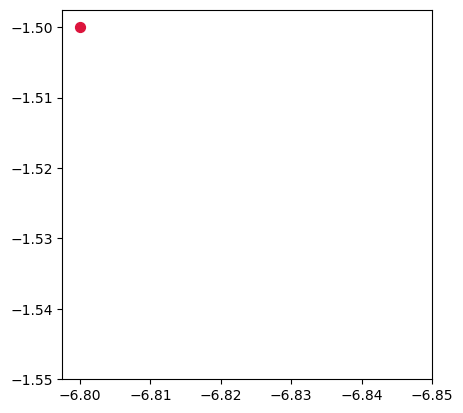

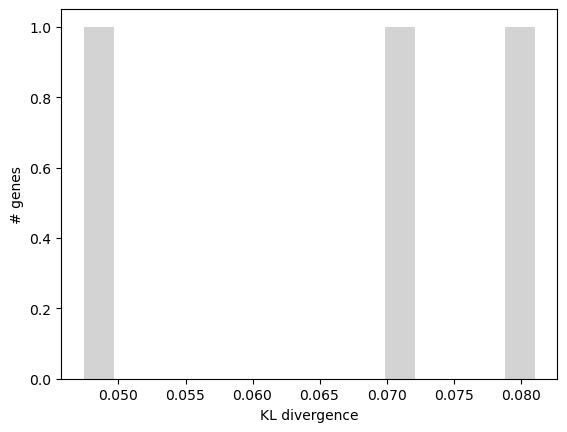

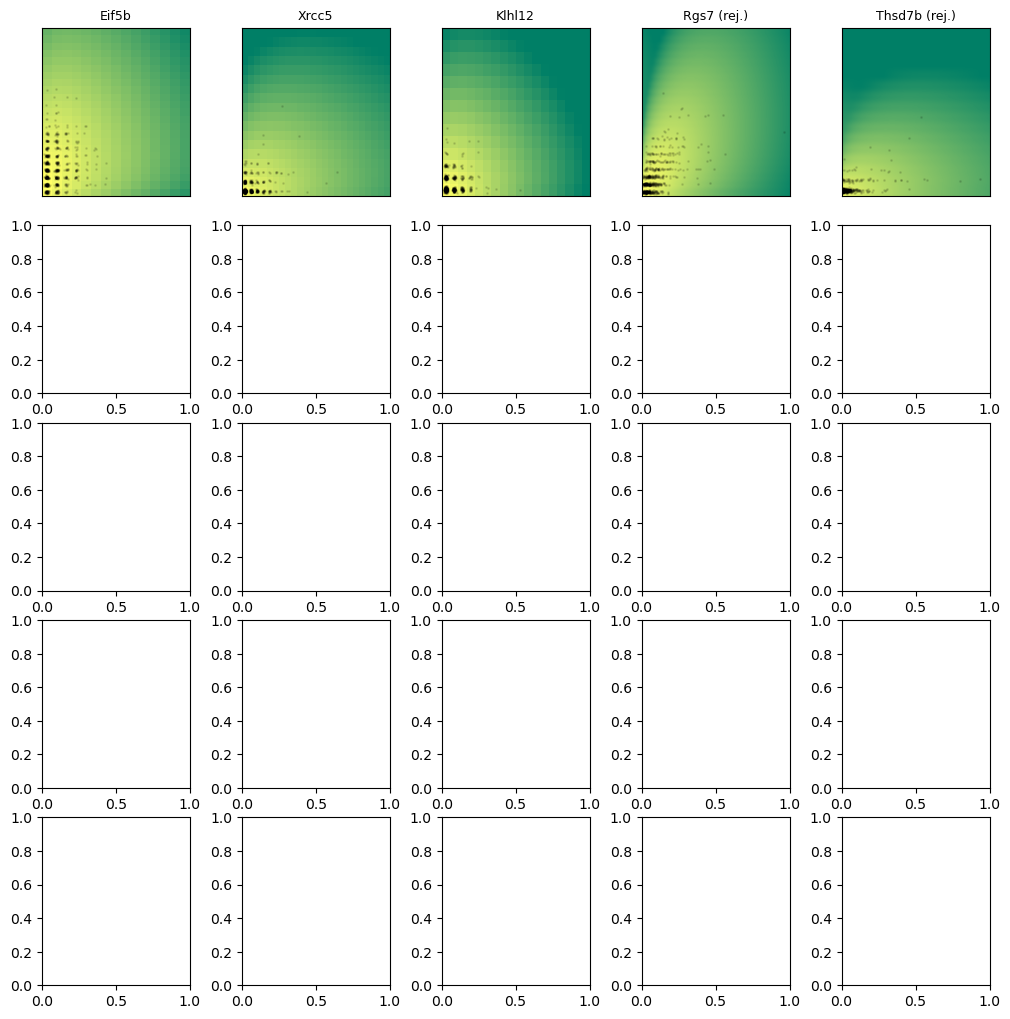

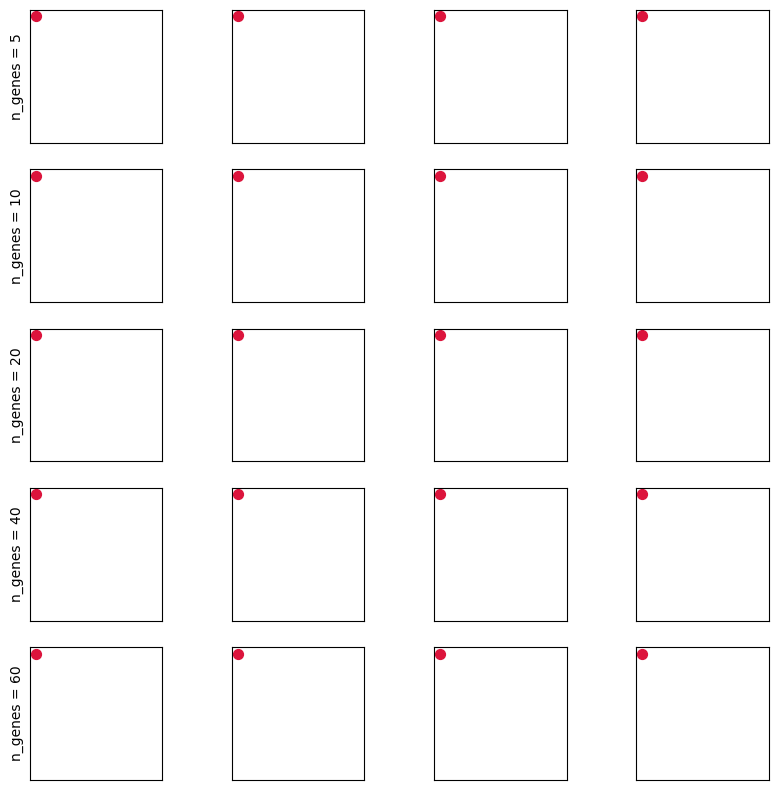

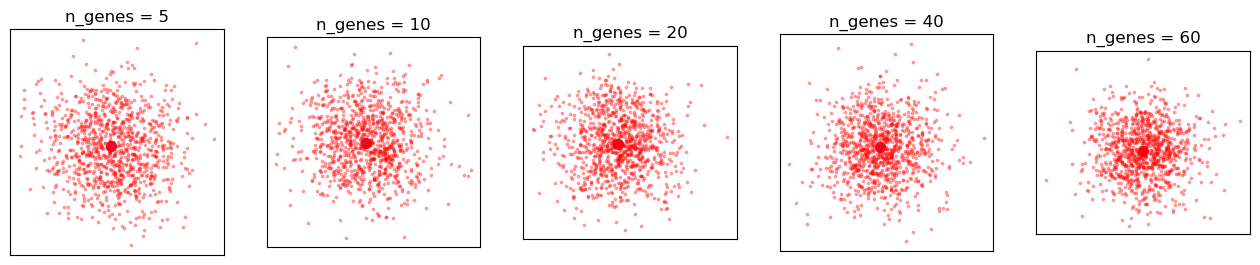

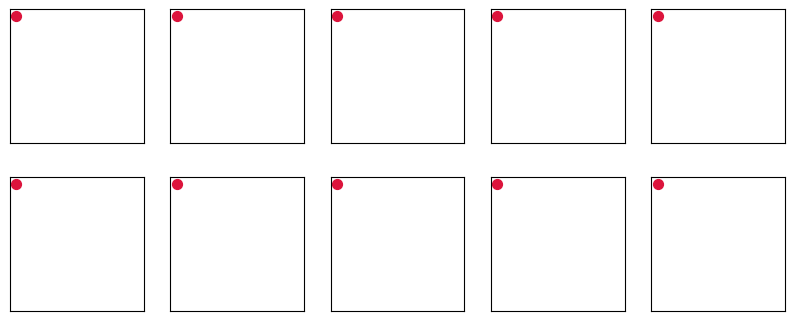

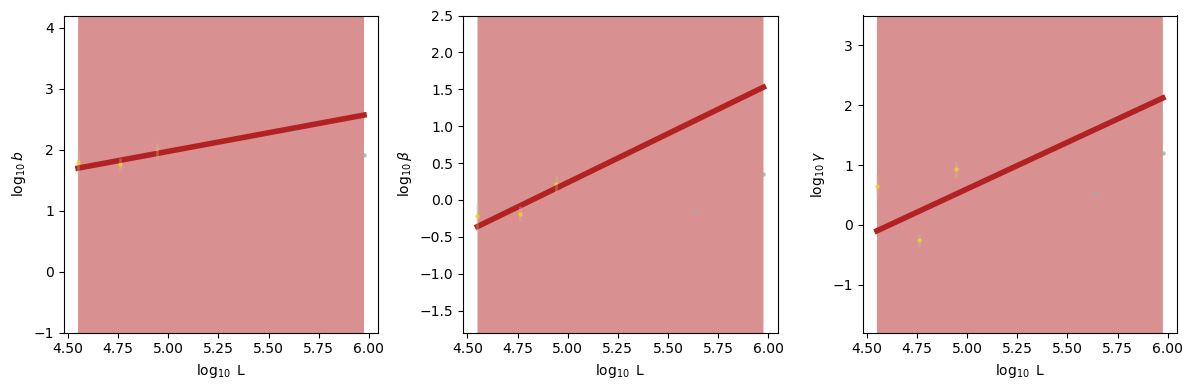

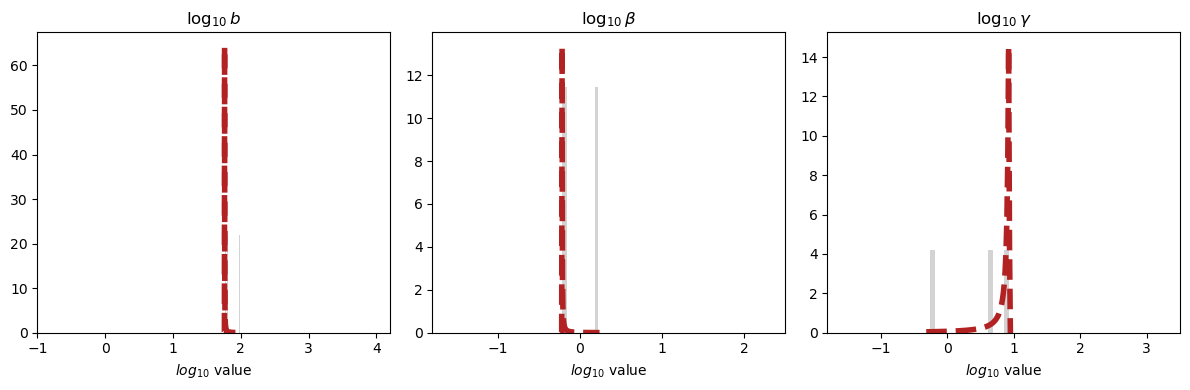

In [30]:
analysis.run_qc(gaba_adata)